In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time,series,format='-',start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-09-02 07:17:00--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-09-02 07:17:00 (5.59 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [5]:
import csv
import pandas as pd

In [6]:
time_steps=[]
temps=[]

In [7]:
df=pd.read_csv('/tmp/daily-min-temperatures.csv',delimiter=',')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


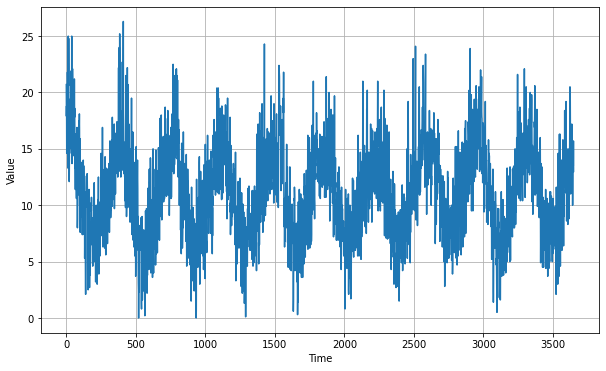

In [8]:
with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader=csv.reader(csvfile,delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_steps.append(step)
    step+=1

series=np.array(temps)
time=np.array(time_steps)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [9]:
split_time=2500
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]
window_size=30
batch_size=32
shuffle_buffer_size=1000

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset=dataset.shuffle(shuffle_buffer_size)
  dataset=dataset.map(lambda w: (w[:-1],w[-1]))
  return dataset.batch(batch_size).prefetch(1)

In [11]:
def model_forecast(model, series, window_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda w:w.batch(window_size))
  dataset=dataset.batch(32).prefetch(1)
  forecast=model.predict(dataset)
  return forecast

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size=64
batch_size=256
train_set=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [13]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(32,5,padding='causal',strides=1,activation='relu',input_shape=[None,1]),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.Dense(30,activation='relu'),
                                    tf.keras.layers.Dense(10,activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x:x*400)
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [15]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history=model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 6s 52ms/step - loss: 31.1418 - mae: 31.6401
Epoch 2/100
10/10 [==============================] - 1s 57ms/step - loss: 30.5657 - mae: 31.0639
Epoch 3/100
10/10 [==============================] - 1s 55ms/step - loss: 29.6745 - mae: 30.1726
Epoch 4/100
10/10 [==============================] - 1s 59ms/step - loss: 28.5571 - mae: 29.0549
Epoch 5/100
10/10 [==============================] - 1s 56ms/step - loss: 27.1948 - mae: 27.6923
Epoch 6/100
10/10 [==============================] - 1s 58ms/step - loss: 25.4979 - mae: 25.9952
Epoch 7/100
10/10 [==============================] - 1s 58ms/step - loss: 23.3389 - mae: 23.8356
Epoch 8/100
10/10 [==============================] - 1s 58ms/step - loss: 20.5994 - mae: 21.0955
Epoch 9/100
10/10 [==============================] - 1s 54ms/step - loss: 17.2908 - mae: 17.7857
Epoch 10/100
10/10 [==============================] - 1s 58ms/step - loss: 13.6041 - mae: 14.0968
Epoch 11/100
10/10 [=========

(1e-08, 0.0001, 0.0, 60.0)

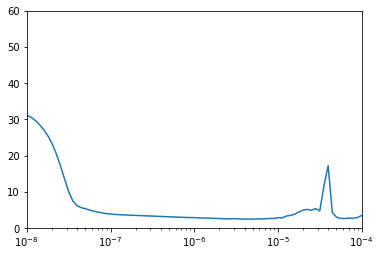

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(60,5,padding='causal',strides=1,activation='relu',input_shape=[None,1]),
                                    tf.keras.layers.LSTM(6,return_sequences=True),
                                    tf.keras.layers.LSTM(6,return_sequences=True),
                                    tf.keras.layers.Dense(30,activation='relu'),
                                    tf.keras.layers.Dense(10,activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x:x*400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 5s 32ms/step - loss: 7.1091 - mae: 7.5928
Epoch 2/150
25/25 [==============================] - 1s 32ms/step - loss: 2.9701 - mae: 3.4387
Epoch 3/150
25/25 [==============================] - 1s 31ms/step - loss: 2.4639 - mae: 2.9258
Epoch 4/150
25/25 [==============================] - 1s 33ms/step - loss: 2.3808 - mae: 2.8419
Epoch 5/150
25/25 [==============================] - 1s 33ms/step - loss: 2.4096 - mae: 2.8716
Epoch 6/150
25/25 [==============================] - 1s 32ms/step - loss: 2.4394 - mae: 2.9017
Epoch 7/150
25/25 [==============================] - 1s 33ms/step - loss: 2.4945 - mae: 2.9569
Epoch 8/150
25/25 [==============================] - 1s 32ms/step - loss: 2.2997 - mae: 2.7591
Epoch 9/150
25/25 [==============================] - 1s 31ms/step - loss: 2.2903 - mae: 2.7493
Epoch 10/150
25/25 [==============================] - 1s 33ms/step - loss: 2.3048 - mae: 2.7634
Epoch 11/150
25/25 [=============================

In [18]:
rnn_forecast=model_forecast(model,series[...,np.newaxis],window_size)
rnn_forecast=rnn_forecast[split_time-window_size:-1,-1,0]

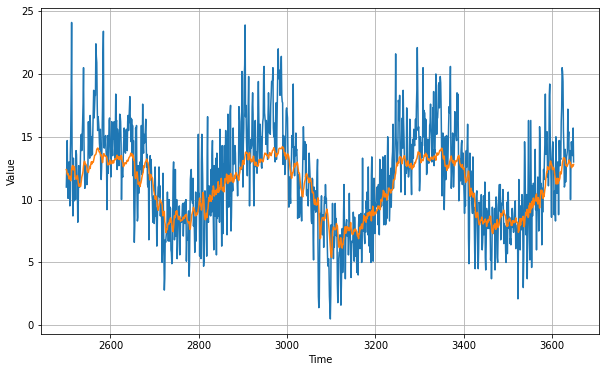

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.1684148

In [21]:
print(rnn_forecast)

[12.392141  12.295079  12.045473  ... 12.769349  12.6591835 12.793848 ]
